In [ ]:
!pip -q install optuna opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.3 MB/s eta 0:00:00


In [ ]:
import os, cv2, gc
import warnings
import random
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.random import set_seed
from typing import Any, Tuple, Dict, List, Union
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, DenseNet121, EfficientNetB0
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.backend import clear_session
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

warnings.filterwarnings(action="ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH = "/content/drive/MyDrive/hyperparameter analysis"

In [ ]:
# Set random seed to ensure code is reproducible
SEED = 42

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    set_seed(seed)
    os.environ['PYTHONHASHSEED']=str(SEED)

set_random_seed(SEED)

## Load the dataset

In [ ]:
# Load dataset
DATASET = "cifar100"
(X_train, y_train), (X_val, y_val) = getattr(datasets, DATASET).load_data()
X_train.shape, X_val.shape

169001437/169001437 [==============================] - 12s 0us/step


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
print(y_train.shape, y_val.shape)

(50000, 1) (10000, 1)


## Visualise Data Samples

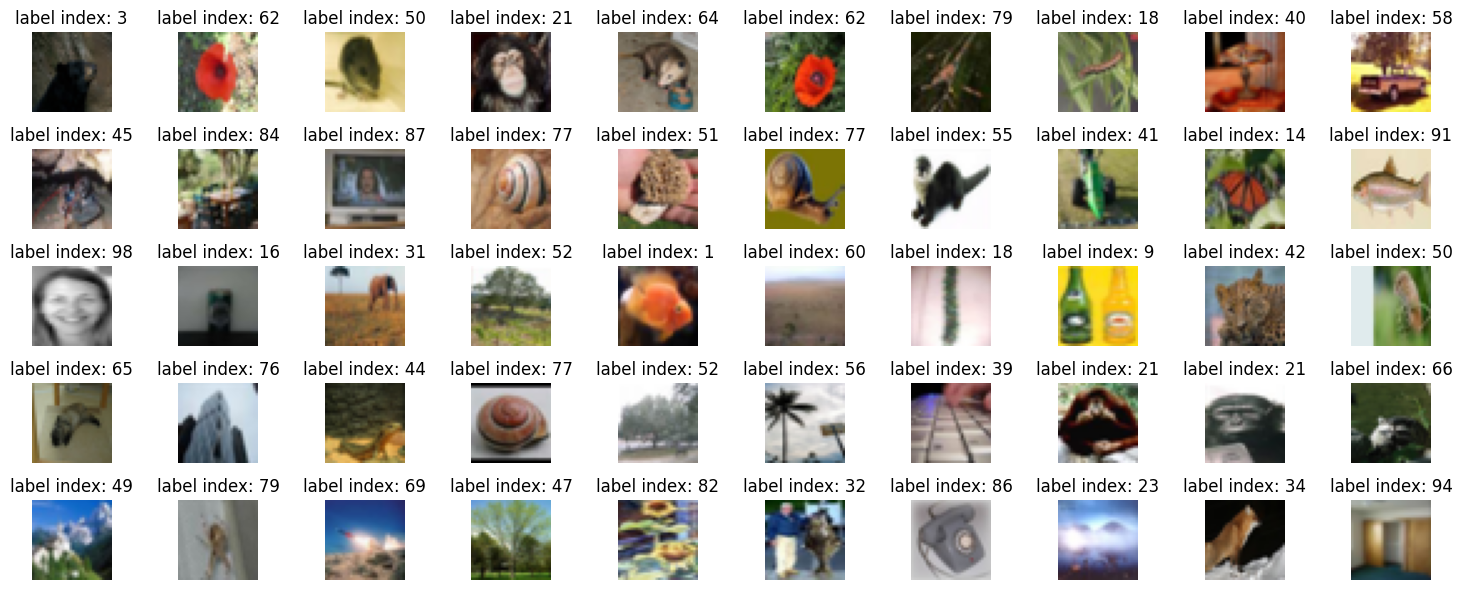

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(15, 6))

indexes = random.sample(range(len(X_train)), 50)
axes = axes.flatten()
for index, ax in zip(indexes, axes):
  ax.set_title(f"label index: {y_train[index][0]}")
  ax.imshow(X_train[index])
  ax.set_axis_off()

fig.tight_layout()
plt.savefig(f'{DATASET} sample images.png')
plt.show()

### Scale Data from range (0 - 255) to range (0 - 1)

In [ ]:
X_train, X_val = X_train / 255.0, X_val / 255.0

## Define Utility Functions

In [ ]:
def build_model(base_model: Model, num_classes: int, dropout_rate: float) -> Sequential:
    """
    Build neural network model.

    Args:
        base_model (Model): Pre-trained base model to build upon.
        num_classes (int): Number of output classes.
        dropout_rate (float): Dropout rate to apply after the Flatten layer.

    Returns:
        Sequential: A new sequential model with added layers.
    """

    # Create a new sequential model
    model = Sequential()

    # Add the pre-trained base model
    model.add(base_model)

    # Add a Flatten layer to convert output of base model to 1D array
    model.add(Flatten())

    # Add a Dropout layer to help prevent overfitting
    model.add(Dropout(dropout_rate))

    # Add a Dense layer with softmax activation for classification
    model.add(Dense(num_classes, activation="softmax"))

    return model

In [ ]:
def get_predictions(model: Model, X: np.ndarray) -> np.ndarray:
    """
    Get model predictions and corresponding labels.

    Args:
        model (Model): Trained neural network model.
        X (np.ndarray): Input data for prediction.

    Returns:
        tuple:
            - np.ndarray: Predicted probabilities for each class.
            - np.ndarray: Predicted labels (class indices) for each sample.
    """

    # Get predicted probabilities for each class
    proba = model.predict(X)

    # Get predicted labels by selecting the class index with highest probability
    labels = np.argmax(proba, axis=-1)

    return proba, labels

In [ ]:
def compute_f1_precision_recall_auc(
    y_true: np.ndarray,
    pred_proba: np.ndarray,
    y_pred: np.ndarray) -> Tuple[float, float, float, float]:
    """
    Compute F1 score, precision, recall, and AUC-ROC for predicted data.

    Args:
        y_true (np.ndarray): Ground truth labels.
        pred_proba (np.ndarray): Predicted probabilities for each class.
        y_pred (np.ndarray): Predicted labels.

    Returns:
        tuple:
            - float: Macro-averaged F1 score.
            - float: Area under the ROC curve (AUC-ROC).
    """

    # Compute F1 score using macro-averaging
    f1 = f1_score(y_true, y_pred, average="macro")

    # Compute precision using macro-averaging
    precision = precision_score(y_true, y_pred, average="macro")

    # Compute recall using macro-averaging
    recall = recall_score(y_true, y_pred, average="macro")

    # Compute AUC-ROC using One-vs-Rest (OvR) strategy
    auc = roc_auc_score(y_true, pred_proba, multi_class="ovr")

    return f1, precision, recall, auc

## Create and Instantiate CollectorQueue Class and Object

In [ ]:
class CollectorQueue:
    """
    A queue-like structure to collect and manage experiment information, metrics, and histories.

    Attributes:
        trial (List[int]): List to store experiment indices.
        metrics (List[Dict[str, float]]): List to store metric dictionaries.
        histories (List[Dict[str, Any]]): List to store history dictionaries.
    """

    def __init__(self):
        self.trial: List[int] = []
        self.metrics: List[Dict[str, float]] = []
        self.histories: List[Dict[str, Any]] = []

    def enqueue(self, trial_idx: int, metrics: Dict[str, float], history: Dict[str, Any]):
        """Add experiment information, metrics, and history to the collector."""
        self.trial.append(trial_idx)
        self.metrics.append(metrics)
        self.histories.append(history)

    def clear(self):
        """Clear all stored trial information, metrics, and histories."""
        self.trial = []
        self.metrics = []
        self.histories = []
        return self


In [ ]:
queue = CollectorQueue()

## Define Objective Function for Hyper-parameter Searching

In [ ]:
def objective_func(
    trial: optuna.trial.Trial,
    base_model: Model,
    num_classes: int,
    hyperparameter_space_dict: Dict[str, Any],
    dataset_dict: Dict[str, np.ndarray],
    metric_weights: Dict[str, float],
    ) -> float:

    """
    Objective function for hyperparameter optimization using Optuna.

    Args:
        trial (optuna.trial.Trial): Optuna trial object.
        base_model (Model):  base model.
        num_classes (int): Number of output classes.
        hyperparameter_space_dict (Dict[str, Any]): Dictionary of hyperparameter spaces.
        dataset_dict (Dict[str, np.ndarray]): Dictionary containing dataset arrays.
        metric_weights (Dict[str, float]): Weights for different metrics.

    Returns:
        float: Weighted sum of metrics as the optimization objective.
    """
    clear_session()

    # Check if metric weights sum to 1.0
    if sum(metric_weights.values()) != 1.0:
        raise ValueError("sum of values of metric_weights must equate to 1.0")

    # Hyperparameter space suggestions
    dropout_rate = trial.suggest_float("dropout_rate", **hyperparameter_space_dict["dropout_rate"])
    optimizer = trial.suggest_categorical("optimizer", hyperparameter_space_dict["optimizer"])
    learning_rate = trial.suggest_float("learning_rate", **hyperparameter_space_dict["learning_rate"])
    batch_size = trial.suggest_int("batch_size", **hyperparameter_space_dict["batch_size"])
    epochs = trial.suggest_int("epochs", **hyperparameter_space_dict["epochs"])

    # Build model
    model = build_model(base_model, num_classes, dropout_rate=dropout_rate)

    # Compile the model
    model.compile(
        optimizer=optimizer(learning_rate=learning_rate),
        loss=SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"]
    )

    # Train model
    model_history = model.fit(
        dataset_dict["X_train"],
        dataset_dict["y_train"],
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        validation_data=(dataset_dict["X_val"], dataset_dict["y_val"]),
        verbose=0,
    )

    # Compute validation metrics
    val_pred_proba, val_pred_labels = get_predictions(model, X_val)
    val_accuracy = max(model_history.history["val_accuracy"])
    val_f1, val_precision, val_recall, val_auc = compute_f1_precision_recall_auc(
        y_val.reshape(-1), val_pred_proba, val_pred_labels)

    # Store metrics and history
    metrics = {
       "model_val_accuracy": val_accuracy,
       "model_val_f1": val_f1,
       "model_val_precision": val_precision,
       "model_val_recall": val_recall,
       "model_val_auc": val_auc,
    }
    queue.enqueue(trial.number, metrics, model_history.history)

    # Calculate objective based on weighted sum of metrics
    objective = (
        (val_accuracy * metric_weights["accuracy"]) +
        (val_f1 * metric_weights["f1"]) +
        (val_precision * metric_weights["precision"]) +
        (val_recall * metric_weights["recall"]) +
        (val_auc * metric_weights["auc"])
    )

    # Prune the trial if necessary
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return objective

## Define Constant Parameters for Objective Function

In [ ]:
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = np.unique(y_train).shape[0]
HYPERPARAMETER_SPACE_DICT = {
    "dropout_rate": {"low": 0.05, "high": 0.3, "step": None, "log": False},
    "optimizer": [SGD, Adam],
    "learning_rate": {"low": 1e-5, "high": 1e-3, "step": None, "log": False},
    "batch_size": {"low": 32, "high": 256, "step": 32, "log": False},
    "epochs": {"low": 10, "high": 50, "step": 10, "log": False},
}

DATASET_DICT = {
    "X_train": X_train,
    "y_train": y_train,
    "X_val": X_val,
    "y_val": y_val,
}

METRIC_WEIGHTS = {
    "accuracy": 1/5,
    "f1": 1/5,
    "precision": 1/5,
    "recall": 1/5,
    "auc": 1/5
}

In [ ]:
NUM_STUDY_TRIALS = 30
SAMPLER_SEED = 42
SAMPLER = "RandomSampler"  # "TPESampler"
PRUNER = None # "MedianPruner"
STUDY_DIR = f"{BASE_PATH}/hyperparameter_tuning_studies/100/{SAMPLER}"
os.makedirs(STUDY_DIR, exist_ok=True)

## Hyper Parameter Tuning Study on VGG16

In [ ]:
# Create a VGG16 model without pre-trained weights
base_model = VGG16(weights=None, include_top=False, input_shape=INPUT_SHAPE)

# Define path for saving study results
study_csv_path = f"{STUDY_DIR}/{DATASET}_VGG16_study.csv"

# Lambda function for defining the optimization objective
objective = lambda trial : objective_func(
    trial,
    base_model=base_model,
    num_classes=NUM_CLASSES,
    hyperparameter_space_dict=HYPERPARAMETER_SPACE_DICT,
    dataset_dict=DATASET_DICT,
    metric_weights=METRIC_WEIGHTS,
)

# Create an Optuna study
study = optuna.create_study(
    study_name="VGG16 Study",
    direction="maximize",
    pruner=getattr(optuna.pruners, PRUNER)() if (PRUNER is not None) else None,
    sampler=getattr(optuna.samplers, SAMPLER)(seed=SAMPLER_SEED) if (SAMPLER is not None) else None,
)

# Optimize the study's objective function
study.optimize(objective, n_trials=NUM_STUDY_TRIALS)

# Extract study results into a DataFrame and include additional information
study_df = study.trials_dataframe()
study_df["model_history"] = queue.histories
study_df["val_metrics"] = queue.metrics

# Save results to a CSV file
study_df.to_csv(study_csv_path, index=False)

# Clean up resources: delete base_model, collect garbage, clear session, and clear queue
del base_model
gc.collect()
clear_session()
queue.clear()

[I 2023-09-01 07:32:48,982] A new study created in memory with name: VGG16 Study


313/313 [==============================] - 3s 7ms/step


[I 2023-09-01 07:37:30,002] Trial 0 finished with value: 0.12754158400611215 and parameters: {'dropout_rate': 0.1436350297118406, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006026718993550663, 'batch_size': 64, 'epochs': 10}. Best is trial 0 with value: 0.12754158400611215.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 08:11:57,012] Trial 1 finished with value: 0.14567549546857592 and parameters: {'dropout_rate': 0.06452090304204987, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007109918520180851, 'batch_size': 32, 'epochs': 50}. Best is trial 1 with value: 0.14567549546857592.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 08:23:42,993] Trial 2 finished with value: 0.11378205161824259 and parameters: {'dropout_rate': 0.2581106602001054, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019157046475489948, 'batch_size': 96, 'epochs': 30}. Best is trial 1 with value: 0.14567549546857592.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 08:31:41,124] Trial 3 finished with value: 0.5182093666019584 and parameters: {'dropout_rate': 0.15798625466052896, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0001480989220455214, 'batch_size': 96, 'epochs': 20}. Best is trial 3 with value: 0.5182093666019584.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 08:35:05,625] Trial 4 finished with value: 0.17984170409427047 and parameters: {'dropout_rate': 0.16401749605425897, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005190920940294755, 'batch_size': 160, 'epochs': 10}. Best is trial 3 with value: 0.5182093666019584.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 08:49:47,317] Trial 5 finished with value: 0.5125743247943944 and parameters: {'dropout_rate': 0.20188621297535958, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0009493966818807999, 'batch_size': 256, 'epochs': 50}. Best is trial 3 with value: 0.5182093666019584.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 09:11:00,660] Trial 6 finished with value: 0.5693071180305385 and parameters: {'dropout_rate': 0.1261534422933427, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0004457509688022053, 'batch_size': 32, 'epochs': 30}. Best is trial 6 with value: 0.5693071180305385.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 09:22:20,333] Trial 7 finished with value: 0.1983830606209765 and parameters: {'dropout_rate': 0.0585971302788046, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006658970615104422, 'batch_size': 96, 'epochs': 30}. Best is trial 6 with value: 0.5693071180305385.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 09:36:53,487] Trial 8 finished with value: 0.5778682422418604 and parameters: {'dropout_rate': 0.1866775698358199, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0007773814951275034, 'batch_size': 256, 'epochs': 50}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 09:50:32,268] Trial 9 finished with value: 0.16065479209878825 and parameters: {'dropout_rate': 0.1994749947027713, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00020402303379495374, 'batch_size': 32, 'epochs': 20}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 10:02:05,449] Trial 10 finished with value: 0.5724720611467138 and parameters: {'dropout_rate': 0.14716932242237052, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003631857934266534, 'batch_size': 96, 'epochs': 30}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 10:05:13,958] Trial 11 finished with value: 0.1319781369048906 and parameters: {'dropout_rate': 0.08523105624369066, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000987018067234512, 'batch_size': 224, 'epochs': 10}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 10:08:16,596] Trial 12 finished with value: 0.12370827795809611 and parameters: {'dropout_rate': 0.0513805292809006, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007317170963605775, 'batch_size': 224, 'epochs': 10}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 10:12:13,895] Trial 13 finished with value: 0.5690355686089345 and parameters: {'dropout_rate': 0.13961643213606817, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0006270651455592824, 'batch_size': 96, 'epochs': 10}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 10:21:02,594] Trial 14 finished with value: 0.5738791731302172 and parameters: {'dropout_rate': 0.12774558042891554, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.000641181896641661, 'batch_size': 256, 'epochs': 30}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 10:30:11,639] Trial 15 finished with value: 0.5696752520957279 and parameters: {'dropout_rate': 0.07989856148457543, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005656644255938013, 'batch_size': 224, 'epochs': 30}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 10:57:17,495] Trial 16 finished with value: 0.4117394736424014 and parameters: {'dropout_rate': 0.18068320734549853, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0001168125127233714, 'batch_size': 32, 'epochs': 40}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 11:11:02,685] Trial 17 finished with value: 0.5734851862433817 and parameters: {'dropout_rate': 0.12858899526908169, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0002567993068573862, 'batch_size': 128, 'epochs': 40}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 11:25:29,289] Trial 18 finished with value: 0.5727929690285615 and parameters: {'dropout_rate': 0.10719954137290562, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00016960907438146438, 'batch_size': 256, 'epochs': 50}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 11:33:49,224] Trial 19 finished with value: 0.10652006088516319 and parameters: {'dropout_rate': 0.20835093912760588, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019470435829717548, 'batch_size': 256, 'epochs': 30}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 11:46:53,481] Trial 20 finished with value: 0.10408050160362284 and parameters: {'dropout_rate': 0.25186003879101565, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00011895140528239999, 'batch_size': 64, 'epochs': 30}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 3s 7ms/step


[I 2023-09-01 11:53:28,210] Trial 21 finished with value: 0.10414588074479406 and parameters: {'dropout_rate': 0.2545036914806233, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005156398295517901, 'batch_size': 128, 'epochs': 20}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 12:05:59,405] Trial 22 finished with value: 0.10405960391569256 and parameters: {'dropout_rate': 0.0799663418334207, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003299709027005477, 'batch_size': 160, 'epochs': 40}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 12:12:34,399] Trial 23 finished with value: 0.10405960391569256 and parameters: {'dropout_rate': 0.14090740059482348, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00025926447286711053, 'batch_size': 128, 'epochs': 20}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 12:26:21,486] Trial 24 finished with value: 0.10405960391569256 and parameters: {'dropout_rate': 0.1212101235943669, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005076522329965729, 'batch_size': 32, 'epochs': 20}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 12:31:56,599] Trial 25 finished with value: 0.10405960391569256 and parameters: {'dropout_rate': 0.2770664714916634, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0004945582326747874, 'batch_size': 256, 'epochs': 20}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 12:46:51,306] Trial 26 finished with value: 0.10405960391569256 and parameters: {'dropout_rate': 0.21803388685146963, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000730934185125741, 'batch_size': 96, 'epochs': 40}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 12:50:38,217] Trial 27 finished with value: 0.10405960391569256 and parameters: {'dropout_rate': 0.2083824276902237, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0008369494706333456, 'batch_size': 96, 'epochs': 10}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 12:56:55,576] Trial 28 finished with value: 0.10405960391569256 and parameters: {'dropout_rate': 0.06019378538869098, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 2.6421950638577592e-05, 'batch_size': 160, 'epochs': 20}. Best is trial 8 with value: 0.5778682422418604.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 12:59:50,728] Trial 29 finished with value: 0.10405960391569256 and parameters: {'dropout_rate': 0.21129319760236248, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00039286799283753205, 'batch_size': 256, 'epochs': 10}. Best is trial 8 with value: 0.5778682422418604.


## Hyper Parameter Tuning Study on MobileNetV2

In [ ]:
# Create a MobileNetV2 model without pre-trained weights
base_model = MobileNetV2(weights=None, include_top=False, input_shape=INPUT_SHAPE)

# Define path for saving study results
study_csv_path = f"{STUDY_DIR}/{DATASET}_MobileNetV2_study.csv"

# Lambda function for defining the optimization objective
objective = lambda trial : objective_func(
    trial,
    base_model=base_model,
    num_classes=NUM_CLASSES,
    hyperparameter_space_dict=HYPERPARAMETER_SPACE_DICT,
    dataset_dict=DATASET_DICT,
    metric_weights=METRIC_WEIGHTS,
)

# create optuna study
study = optuna.create_study(
    study_name="MobileNetV2 Study",
    direction="maximize",
    pruner=getattr(optuna.pruners, PRUNER)() if (PRUNER is not None) else None,
    sampler=getattr(optuna.samplers, SAMPLER)(seed=SAMPLER_SEED) if (SAMPLER is not None) else None,
)

# optimize study objective
study.optimize(objective, n_trials=NUM_STUDY_TRIALS)

# Extract study results into a DataFrame and include additional information
study_df = study.trials_dataframe()
study_df["model_history"] = queue.histories
study_df["val_metrics"] = queue.metrics

# Save results to a CSV file
study_df.to_csv(study_csv_path, index=False)

# Clean up resources: delete base_model, collect garbage, clear session, and clear queue
del base_model
gc.collect()
clear_session()
queue.clear()

[I 2023-09-01 12:59:52,128] A new study created in memory with name: MobileNetV2 Study


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 13:03:36,550] Trial 0 finished with value: 0.21645638086281582 and parameters: {'dropout_rate': 0.1436350297118406, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006026718993550663, 'batch_size': 64, 'epochs': 10}. Best is trial 0 with value: 0.21645638086281582.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 13:29:52,533] Trial 1 finished with value: 0.39191833852649705 and parameters: {'dropout_rate': 0.06452090304204987, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007109918520180851, 'batch_size': 32, 'epochs': 50}. Best is trial 1 with value: 0.39191833852649705.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 13:39:12,864] Trial 2 finished with value: 0.39030433372585216 and parameters: {'dropout_rate': 0.2581106602001054, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019157046475489948, 'batch_size': 96, 'epochs': 30}. Best is trial 1 with value: 0.39191833852649705.


313/313 [==============================] - 2s 4ms/step


[I 2023-09-01 13:45:55,103] Trial 3 finished with value: 0.3953382603869092 and parameters: {'dropout_rate': 0.15798625466052896, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0001480989220455214, 'batch_size': 96, 'epochs': 20}. Best is trial 3 with value: 0.3953382603869092.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 13:48:57,446] Trial 4 finished with value: 0.38593040716905924 and parameters: {'dropout_rate': 0.16401749605425897, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005190920940294755, 'batch_size': 160, 'epochs': 10}. Best is trial 3 with value: 0.3953382603869092.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 14:02:23,979] Trial 5 finished with value: 0.3987157316932335 and parameters: {'dropout_rate': 0.20188621297535958, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0009493966818807999, 'batch_size': 256, 'epochs': 50}. Best is trial 5 with value: 0.3987157316932335.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 14:20:25,562] Trial 6 finished with value: 0.495746038850035 and parameters: {'dropout_rate': 0.1261534422933427, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0004457509688022053, 'batch_size': 32, 'epochs': 30}. Best is trial 6 with value: 0.495746038850035.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 14:29:46,080] Trial 7 finished with value: 0.4880983689145671 and parameters: {'dropout_rate': 0.0585971302788046, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006658970615104422, 'batch_size': 96, 'epochs': 30}. Best is trial 6 with value: 0.495746038850035.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 14:43:34,707] Trial 8 finished with value: 0.47037064342128354 and parameters: {'dropout_rate': 0.1866775698358199, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0007773814951275034, 'batch_size': 256, 'epochs': 50}. Best is trial 6 with value: 0.495746038850035.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 14:54:26,522] Trial 9 finished with value: 0.5024551588164891 and parameters: {'dropout_rate': 0.1994749947027713, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00020402303379495374, 'batch_size': 32, 'epochs': 20}. Best is trial 9 with value: 0.5024551588164891.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 15:04:10,306] Trial 10 finished with value: 0.494268259216174 and parameters: {'dropout_rate': 0.14716932242237052, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003631857934266534, 'batch_size': 96, 'epochs': 30}. Best is trial 9 with value: 0.5024551588164891.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 15:07:09,444] Trial 11 finished with value: 0.46403905158648917 and parameters: {'dropout_rate': 0.08523105624369066, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000987018067234512, 'batch_size': 224, 'epochs': 10}. Best is trial 9 with value: 0.5024551588164891.


313/313 [==============================] - 3s 5ms/step


[I 2023-09-01 15:10:05,473] Trial 12 finished with value: 0.43025807764323293 and parameters: {'dropout_rate': 0.0513805292809006, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007317170963605775, 'batch_size': 224, 'epochs': 10}. Best is trial 9 with value: 0.5024551588164891.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 15:13:40,319] Trial 13 finished with value: 0.47506791838279777 and parameters: {'dropout_rate': 0.13961643213606817, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0006270651455592824, 'batch_size': 96, 'epochs': 10}. Best is trial 9 with value: 0.5024551588164891.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 15:22:09,757] Trial 14 finished with value: 0.4823803046708932 and parameters: {'dropout_rate': 0.12774558042891554, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.000641181896641661, 'batch_size': 256, 'epochs': 30}. Best is trial 9 with value: 0.5024551588164891.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 15:30:45,321] Trial 15 finished with value: 0.48944005920039074 and parameters: {'dropout_rate': 0.07989856148457543, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005656644255938013, 'batch_size': 224, 'epochs': 30}. Best is trial 9 with value: 0.5024551588164891.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 15:52:06,129] Trial 16 finished with value: 0.5143833675801248 and parameters: {'dropout_rate': 0.18068320734549853, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0001168125127233714, 'batch_size': 32, 'epochs': 40}. Best is trial 16 with value: 0.5143833675801248.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 16:04:11,638] Trial 17 finished with value: 0.5018059858193608 and parameters: {'dropout_rate': 0.12858899526908169, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0002567993068573862, 'batch_size': 128, 'epochs': 40}. Best is trial 16 with value: 0.5143833675801248.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 16:17:59,724] Trial 18 finished with value: 0.5033208917761607 and parameters: {'dropout_rate': 0.10719954137290562, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00016960907438146438, 'batch_size': 256, 'epochs': 50}. Best is trial 16 with value: 0.5143833675801248.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 16:26:12,054] Trial 19 finished with value: 0.4655486406929932 and parameters: {'dropout_rate': 0.20835093912760588, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019470435829717548, 'batch_size': 256, 'epochs': 30}. Best is trial 16 with value: 0.5143833675801248.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 16:36:45,446] Trial 20 finished with value: 0.5010401757406682 and parameters: {'dropout_rate': 0.25186003879101565, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00011895140528239999, 'batch_size': 64, 'epochs': 30}. Best is trial 16 with value: 0.5143833675801248.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 16:42:42,198] Trial 21 finished with value: 0.5043742186579968 and parameters: {'dropout_rate': 0.2545036914806233, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005156398295517901, 'batch_size': 128, 'epochs': 20}. Best is trial 16 with value: 0.5143833675801248.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 16:54:21,500] Trial 22 finished with value: 0.4961345437386421 and parameters: {'dropout_rate': 0.0799663418334207, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003299709027005477, 'batch_size': 160, 'epochs': 40}. Best is trial 16 with value: 0.5143833675801248.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 17:00:16,629] Trial 23 finished with value: 0.49488717051511627 and parameters: {'dropout_rate': 0.14090740059482348, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00025926447286711053, 'batch_size': 128, 'epochs': 20}. Best is trial 16 with value: 0.5143833675801248.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 17:12:46,280] Trial 24 finished with value: 0.49279079381581126 and parameters: {'dropout_rate': 0.1212101235943669, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005076522329965729, 'batch_size': 32, 'epochs': 20}. Best is trial 16 with value: 0.5143833675801248.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 17:18:18,645] Trial 25 finished with value: 0.37712225108916575 and parameters: {'dropout_rate': 0.2770664714916634, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0004945582326747874, 'batch_size': 256, 'epochs': 20}. Best is trial 16 with value: 0.5143833675801248.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 17:30:43,523] Trial 26 finished with value: 0.5195137056052104 and parameters: {'dropout_rate': 0.21803388685146963, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000730934185125741, 'batch_size': 96, 'epochs': 40}. Best is trial 26 with value: 0.5195137056052104.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 17:34:01,873] Trial 27 finished with value: 0.4990655678829984 and parameters: {'dropout_rate': 0.2083824276902237, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0008369494706333456, 'batch_size': 96, 'epochs': 10}. Best is trial 26 with value: 0.5195137056052104.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 17:40:07,614] Trial 28 finished with value: 0.5175780577294822 and parameters: {'dropout_rate': 0.06019378538869098, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 2.6421950638577592e-05, 'batch_size': 160, 'epochs': 20}. Best is trial 26 with value: 0.5195137056052104.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 17:43:17,072] Trial 29 finished with value: 0.5016617893930017 and parameters: {'dropout_rate': 0.21129319760236248, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00039286799283753205, 'batch_size': 256, 'epochs': 10}. Best is trial 26 with value: 0.5195137056052104.


## Hyper Parameter Tuning Study on ResNet50

In [ ]:
# Create a ResNet50 model without pre-trained weights
base_model = ResNet50(weights=None, include_top=False, input_shape=INPUT_SHAPE)

# Define path for saving study results
study_csv_path = f"{STUDY_DIR}/{DATASET}_ResNet50_study.csv"

# Lambda function for defining the optimization objective
objective = lambda trial : objective_func(
    trial,
    base_model=base_model,
    num_classes=NUM_CLASSES,
    hyperparameter_space_dict=HYPERPARAMETER_SPACE_DICT,
    dataset_dict=DATASET_DICT,
    metric_weights=METRIC_WEIGHTS,
)

# create optuna study
study = optuna.create_study(
    study_name="ResNet50 Study",
    direction="maximize",
    pruner=getattr(optuna.pruners, PRUNER)() if (PRUNER is not None) else None,
    sampler=getattr(optuna.samplers, SAMPLER)(seed=SAMPLER_SEED) if (SAMPLER is not None) else None,
)

# optimize study objective
study.optimize(objective, n_trials=NUM_STUDY_TRIALS)

# Extract study results into a DataFrame and include additional information
study_df = study.trials_dataframe()
study_df["model_history"] = queue.histories
study_df["val_metrics"] = queue.metrics

# Save results to a CSV file
study_df.to_csv(study_csv_path, index=False)

# Clean up resources: delete base_model, collect garbage, clear session, and clear queue
del base_model
gc.collect()
clear_session()
queue.clear()

[I 2023-09-01 17:43:19,306] A new study created in memory with name: ResNet50 Study


313/313 [==============================] - 4s 8ms/step


[I 2023-09-01 17:48:54,098] Trial 0 finished with value: 0.2880022397754698 and parameters: {'dropout_rate': 0.1436350297118406, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006026718993550663, 'batch_size': 64, 'epochs': 10}. Best is trial 0 with value: 0.2880022397754698.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 18:31:59,897] Trial 1 finished with value: 0.39768850195161637 and parameters: {'dropout_rate': 0.06452090304204987, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007109918520180851, 'batch_size': 32, 'epochs': 50}. Best is trial 1 with value: 0.39768850195161637.


313/313 [==============================] - 5s 8ms/step


[I 2023-09-01 18:45:07,842] Trial 2 finished with value: 0.39343718530640437 and parameters: {'dropout_rate': 0.2581106602001054, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019157046475489948, 'batch_size': 96, 'epochs': 30}. Best is trial 1 with value: 0.39768850195161637.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 18:54:36,622] Trial 3 finished with value: 0.4171407031247107 and parameters: {'dropout_rate': 0.15798625466052896, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0001480989220455214, 'batch_size': 96, 'epochs': 20}. Best is trial 3 with value: 0.4171407031247107.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 18:58:22,776] Trial 4 finished with value: 0.42073173268168146 and parameters: {'dropout_rate': 0.16401749605425897, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005190920940294755, 'batch_size': 160, 'epochs': 10}. Best is trial 4 with value: 0.42073173268168146.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-01 19:13:41,246] Trial 5 finished with value: 0.4360160067710031 and parameters: {'dropout_rate': 0.20188621297535958, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0009493966818807999, 'batch_size': 256, 'epochs': 50}. Best is trial 5 with value: 0.4360160067710031.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 19:41:41,073] Trial 6 finished with value: 0.5092810707973773 and parameters: {'dropout_rate': 0.1261534422933427, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0004457509688022053, 'batch_size': 32, 'epochs': 30}. Best is trial 6 with value: 0.5092810707973773.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 19:54:45,028] Trial 7 finished with value: 0.5181283357604021 and parameters: {'dropout_rate': 0.0585971302788046, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006658970615104422, 'batch_size': 96, 'epochs': 30}. Best is trial 7 with value: 0.5181283357604021.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 20:10:32,660] Trial 8 finished with value: 0.5289304705706941 and parameters: {'dropout_rate': 0.1866775698358199, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0007773814951275034, 'batch_size': 256, 'epochs': 50}. Best is trial 8 with value: 0.5289304705706941.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 20:27:47,620] Trial 9 finished with value: 0.5294002686304462 and parameters: {'dropout_rate': 0.1994749947027713, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00020402303379495374, 'batch_size': 32, 'epochs': 20}. Best is trial 9 with value: 0.5294002686304462.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 20:41:39,362] Trial 10 finished with value: 0.5334455256353113 and parameters: {'dropout_rate': 0.14716932242237052, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003631857934266534, 'batch_size': 96, 'epochs': 30}. Best is trial 10 with value: 0.5334455256353113.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 20:45:12,417] Trial 11 finished with value: 0.4938176300544976 and parameters: {'dropout_rate': 0.08523105624369066, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000987018067234512, 'batch_size': 224, 'epochs': 10}. Best is trial 10 with value: 0.5334455256353113.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-01 20:48:39,102] Trial 12 finished with value: 0.4625921913049103 and parameters: {'dropout_rate': 0.0513805292809006, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007317170963605775, 'batch_size': 224, 'epochs': 10}. Best is trial 10 with value: 0.5334455256353113.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 20:53:42,318] Trial 13 finished with value: 0.5203904530314754 and parameters: {'dropout_rate': 0.13961643213606817, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0006270651455592824, 'batch_size': 96, 'epochs': 10}. Best is trial 10 with value: 0.5334455256353113.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 21:03:27,343] Trial 14 finished with value: 0.5351226981887238 and parameters: {'dropout_rate': 0.12774558042891554, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.000641181896641661, 'batch_size': 256, 'epochs': 30}. Best is trial 14 with value: 0.5351226981887238.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 21:13:36,383] Trial 15 finished with value: 0.5311278667761627 and parameters: {'dropout_rate': 0.07989856148457543, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005656644255938013, 'batch_size': 224, 'epochs': 30}. Best is trial 14 with value: 0.5351226981887238.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 21:47:58,573] Trial 16 finished with value: 0.5393577871114154 and parameters: {'dropout_rate': 0.18068320734549853, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0001168125127233714, 'batch_size': 32, 'epochs': 40}. Best is trial 16 with value: 0.5393577871114154.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 22:03:57,294] Trial 17 finished with value: 0.540263238271458 and parameters: {'dropout_rate': 0.12858899526908169, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0002567993068573862, 'batch_size': 128, 'epochs': 40}. Best is trial 17 with value: 0.540263238271458.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 22:19:46,693] Trial 18 finished with value: 0.543205135360094 and parameters: {'dropout_rate': 0.10719954137290562, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00016960907438146438, 'batch_size': 256, 'epochs': 50}. Best is trial 18 with value: 0.543205135360094.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 22:29:03,412] Trial 19 finished with value: 0.5163517038826754 and parameters: {'dropout_rate': 0.20835093912760588, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019470435829717548, 'batch_size': 256, 'epochs': 30}. Best is trial 18 with value: 0.543205135360094.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 22:44:48,018] Trial 20 finished with value: 0.5364922763642739 and parameters: {'dropout_rate': 0.25186003879101565, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00011895140528239999, 'batch_size': 64, 'epochs': 30}. Best is trial 18 with value: 0.543205135360094.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 22:52:34,449] Trial 21 finished with value: 0.5371393924318334 and parameters: {'dropout_rate': 0.2545036914806233, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005156398295517901, 'batch_size': 128, 'epochs': 20}. Best is trial 18 with value: 0.543205135360094.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 23:07:04,854] Trial 22 finished with value: 0.5343330450688966 and parameters: {'dropout_rate': 0.0799663418334207, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003299709027005477, 'batch_size': 160, 'epochs': 40}. Best is trial 18 with value: 0.543205135360094.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 23:14:47,387] Trial 23 finished with value: 0.5100958978934514 and parameters: {'dropout_rate': 0.14090740059482348, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00025926447286711053, 'batch_size': 128, 'epochs': 20}. Best is trial 18 with value: 0.543205135360094.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 23:33:46,347] Trial 24 finished with value: 0.5193558245073862 and parameters: {'dropout_rate': 0.1212101235943669, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005076522329965729, 'batch_size': 32, 'epochs': 20}. Best is trial 18 with value: 0.543205135360094.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 23:40:05,126] Trial 25 finished with value: 0.4015149901195504 and parameters: {'dropout_rate': 0.2770664714916634, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0004945582326747874, 'batch_size': 256, 'epochs': 20}. Best is trial 18 with value: 0.543205135360094.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 23:57:19,029] Trial 26 finished with value: 0.5453093400542908 and parameters: {'dropout_rate': 0.21803388685146963, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000730934185125741, 'batch_size': 96, 'epochs': 40}. Best is trial 26 with value: 0.5453093400542908.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-02 00:01:55,965] Trial 27 finished with value: 0.5166494406582685 and parameters: {'dropout_rate': 0.2083824276902237, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0008369494706333456, 'batch_size': 96, 'epochs': 10}. Best is trial 26 with value: 0.5453093400542908.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-02 00:09:31,550] Trial 28 finished with value: 0.5512189439126003 and parameters: {'dropout_rate': 0.06019378538869098, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 2.6421950638577592e-05, 'batch_size': 160, 'epochs': 20}. Best is trial 28 with value: 0.5512189439126003.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-02 00:13:16,118] Trial 29 finished with value: 0.5155250090252449 and parameters: {'dropout_rate': 0.21129319760236248, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00039286799283753205, 'batch_size': 256, 'epochs': 10}. Best is trial 28 with value: 0.5512189439126003.


## Hyper Parameter Tuning Study on DenseNet121

In [ ]:
# Create a DenseNet121 model without pre-trained weights
base_model = DenseNet121(weights=None, include_top=False, input_shape=INPUT_SHAPE)

# Define path for saving study results
study_csv_path = f"{STUDY_DIR}/{DATASET}_DenseNet121_study.csv"

# Lambda function for defining the optimization objective
objective = lambda trial : objective_func(
    trial,
    base_model=base_model,
    num_classes=NUM_CLASSES,
    hyperparameter_space_dict=HYPERPARAMETER_SPACE_DICT,
    dataset_dict=DATASET_DICT,
    metric_weights=METRIC_WEIGHTS,
)

# create optuna study
study = optuna.create_study(
    study_name="DenseNet121 Study",
    direction="maximize",
    pruner=getattr(optuna.pruners, PRUNER)() if (PRUNER is not None) else None,
    sampler=getattr(optuna.samplers, SAMPLER)(seed=SAMPLER_SEED) if (SAMPLER is not None) else None,
)

# optimize study objective
study.optimize(objective, n_trials=NUM_STUDY_TRIALS)

# Extract study results into a DataFrame and include additional information
study_df = study.trials_dataframe()
study_df["model_history"] = queue.histories
study_df["val_metrics"] = queue.metrics

# Save results to a CSV file
study_df.to_csv(study_csv_path, index=False)

# Clean up resources: delete base_model, collect garbage, clear session, and clear queue
del base_model
gc.collect()
clear_session()
queue.clear()

[I 2023-09-02 09:21:13,145] A new study created in memory with name: DenseNet121 Study


313/313 [==============================] - 6s 10ms/step


[I 2023-09-02 09:29:31,905] Trial 0 finished with value: 0.2902510636600561 and parameters: {'dropout_rate': 0.1436350297118406, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006026718993550663, 'batch_size': 64, 'epochs': 10}. Best is trial 0 with value: 0.2902510636600561.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 10:43:10,621] Trial 1 finished with value: 0.4564946993023284 and parameters: {'dropout_rate': 0.06452090304204987, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007109918520180851, 'batch_size': 32, 'epochs': 50}. Best is trial 1 with value: 0.4564946993023284.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 10:59:13,591] Trial 2 finished with value: 0.4274543230129121 and parameters: {'dropout_rate': 0.2581106602001054, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019157046475489948, 'batch_size': 96, 'epochs': 30}. Best is trial 1 with value: 0.4564946993023284.


313/313 [==============================] - 5s 10ms/step


[I 2023-09-02 11:11:48,959] Trial 3 finished with value: 0.47925566125788344 and parameters: {'dropout_rate': 0.15798625466052896, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0001480989220455214, 'batch_size': 96, 'epochs': 20}. Best is trial 3 with value: 0.47925566125788344.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 11:16:00,119] Trial 4 finished with value: 0.4526224278826477 and parameters: {'dropout_rate': 0.16401749605425897, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005190920940294755, 'batch_size': 160, 'epochs': 10}. Best is trial 3 with value: 0.47925566125788344.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 11:30:41,068] Trial 5 finished with value: 0.5104960783960717 and parameters: {'dropout_rate': 0.20188621297535958, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0009493966818807999, 'batch_size': 256, 'epochs': 50}. Best is trial 5 with value: 0.5104960783960717.


313/313 [==============================] - 6s 11ms/step


[I 2023-09-02 12:22:08,376] Trial 6 finished with value: 0.5652908379730404 and parameters: {'dropout_rate': 0.1261534422933427, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0004457509688022053, 'batch_size': 32, 'epochs': 30}. Best is trial 6 with value: 0.5652908379730404.


313/313 [==============================] - 7s 11ms/step


[I 2023-09-02 12:38:10,240] Trial 7 finished with value: 0.5845471495523292 and parameters: {'dropout_rate': 0.0585971302788046, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006658970615104422, 'batch_size': 96, 'epochs': 30}. Best is trial 7 with value: 0.5845471495523292.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 12:54:13,014] Trial 8 finished with value: 0.5797676609573648 and parameters: {'dropout_rate': 0.1866775698358199, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0007773814951275034, 'batch_size': 256, 'epochs': 50}. Best is trial 7 with value: 0.5845471495523292.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 13:25:19,239] Trial 9 finished with value: 0.5791110335165305 and parameters: {'dropout_rate': 0.1994749947027713, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00020402303379495374, 'batch_size': 32, 'epochs': 20}. Best is trial 7 with value: 0.5845471495523292.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 13:43:45,843] Trial 10 finished with value: 0.5867527334963049 and parameters: {'dropout_rate': 0.14716932242237052, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003631857934266534, 'batch_size': 96, 'epochs': 30}. Best is trial 10 with value: 0.5867527334963049.


313/313 [==============================] - 5s 10ms/step


[I 2023-09-02 13:47:32,471] Trial 11 finished with value: 0.5328160452446353 and parameters: {'dropout_rate': 0.08523105624369066, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000987018067234512, 'batch_size': 224, 'epochs': 10}. Best is trial 10 with value: 0.5867527334963049.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 13:51:10,569] Trial 12 finished with value: 0.4978034394187272 and parameters: {'dropout_rate': 0.0513805292809006, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007317170963605775, 'batch_size': 224, 'epochs': 10}. Best is trial 10 with value: 0.5867527334963049.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 13:58:07,933] Trial 13 finished with value: 0.5650291885722687 and parameters: {'dropout_rate': 0.13961643213606817, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0006270651455592824, 'batch_size': 96, 'epochs': 10}. Best is trial 10 with value: 0.5867527334963049.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 14:08:10,661] Trial 14 finished with value: 0.538217432618139 and parameters: {'dropout_rate': 0.12774558042891554, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.000641181896641661, 'batch_size': 256, 'epochs': 30}. Best is trial 10 with value: 0.5867527334963049.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 14:18:53,615] Trial 15 finished with value: 0.5651724697552583 and parameters: {'dropout_rate': 0.07989856148457543, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005656644255938013, 'batch_size': 224, 'epochs': 30}. Best is trial 10 with value: 0.5867527334963049.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 15:21:04,500] Trial 16 finished with value: 0.5856114245166799 and parameters: {'dropout_rate': 0.18068320734549853, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0001168125127233714, 'batch_size': 32, 'epochs': 40}. Best is trial 10 with value: 0.5867527334963049.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 15:40:27,980] Trial 17 finished with value: 0.5857940381330414 and parameters: {'dropout_rate': 0.12858899526908169, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0002567993068573862, 'batch_size': 128, 'epochs': 40}. Best is trial 10 with value: 0.5867527334963049.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 15:56:34,724] Trial 18 finished with value: 0.595222597169579 and parameters: {'dropout_rate': 0.10719954137290562, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00016960907438146438, 'batch_size': 256, 'epochs': 50}. Best is trial 18 with value: 0.595222597169579.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 16:05:48,399] Trial 19 finished with value: 0.5345556085858363 and parameters: {'dropout_rate': 0.20835093912760588, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019470435829717548, 'batch_size': 256, 'epochs': 30}. Best is trial 18 with value: 0.595222597169579.


313/313 [==============================] - 6s 11ms/step


[I 2023-09-02 16:30:25,723] Trial 20 finished with value: 0.5776932133927182 and parameters: {'dropout_rate': 0.25186003879101565, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00011895140528239999, 'batch_size': 64, 'epochs': 30}. Best is trial 18 with value: 0.595222597169579.


313/313 [==============================] - 6s 12ms/step


[I 2023-09-02 16:39:25,527] Trial 21 finished with value: 0.5788574927989247 and parameters: {'dropout_rate': 0.2545036914806233, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005156398295517901, 'batch_size': 128, 'epochs': 20}. Best is trial 18 with value: 0.595222597169579.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 16:56:21,471] Trial 22 finished with value: 0.5785678716467126 and parameters: {'dropout_rate': 0.0799663418334207, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003299709027005477, 'batch_size': 160, 'epochs': 40}. Best is trial 18 with value: 0.595222597169579.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 17:05:29,608] Trial 23 finished with value: 0.554103527700624 and parameters: {'dropout_rate': 0.14090740059482348, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00025926447286711053, 'batch_size': 128, 'epochs': 20}. Best is trial 18 with value: 0.595222597169579.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 17:42:09,589] Trial 24 finished with value: 0.5611669036357925 and parameters: {'dropout_rate': 0.1212101235943669, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005076522329965729, 'batch_size': 32, 'epochs': 20}. Best is trial 18 with value: 0.595222597169579.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 17:48:35,718] Trial 25 finished with value: 0.48850670457568585 and parameters: {'dropout_rate': 0.2770664714916634, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0004945582326747874, 'batch_size': 256, 'epochs': 20}. Best is trial 18 with value: 0.595222597169579.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 18:11:13,559] Trial 26 finished with value: 0.5857769557766307 and parameters: {'dropout_rate': 0.21803388685146963, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000730934185125741, 'batch_size': 96, 'epochs': 40}. Best is trial 18 with value: 0.595222597169579.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 18:17:24,023] Trial 27 finished with value: 0.5656319829374511 and parameters: {'dropout_rate': 0.2083824276902237, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0008369494706333456, 'batch_size': 96, 'epochs': 10}. Best is trial 18 with value: 0.595222597169579.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 18:26:27,628] Trial 28 finished with value: 0.600967311688904 and parameters: {'dropout_rate': 0.06019378538869098, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 2.6421950638577592e-05, 'batch_size': 160, 'epochs': 20}. Best is trial 28 with value: 0.600967311688904.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 18:30:42,001] Trial 29 finished with value: 0.6007440228083438 and parameters: {'dropout_rate': 0.21129319760236248, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00039286799283753205, 'batch_size': 256, 'epochs': 10}. Best is trial 28 with value: 0.600967311688904.


## Hyper Parameter Tuning Study on EfficientNetB0

---



In [ ]:
# Create an EfficientNetB0 model without pre-trained weights
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=INPUT_SHAPE)

# Define path for saving study results
study_csv_path = f"{STUDY_DIR}/{DATASET}_EfficientNetB0_study.csv"

# Lambda function for defining the optimization objective
objective = lambda trial : objective_func(
    trial,
    base_model=base_model,
    num_classes=NUM_CLASSES,
    hyperparameter_space_dict=HYPERPARAMETER_SPACE_DICT,
    dataset_dict=DATASET_DICT,
    metric_weights=METRIC_WEIGHTS,
)

# create optuna study
study = optuna.create_study(
    study_name="EfficientNetB0 Study",
    direction="maximize",
    pruner=getattr(optuna.pruners, PRUNER)() if (PRUNER is not None) else None,
    sampler=getattr(optuna.samplers, SAMPLER)(seed=SAMPLER_SEED) if (SAMPLER is not None) else None,
)

# optimize study objective
study.optimize(objective, n_trials=NUM_STUDY_TRIALS)

# Extract study results into a DataFrame and include additional information
study_df = study.trials_dataframe()
study_df["model_history"] = queue.histories
study_df["val_metrics"] = queue.metrics

# Save results to a CSV file
study_df.to_csv(study_csv_path, index=False)

# Clean up resources: delete base_model, collect garbage, clear session, and clear queue
del base_model
gc.collect()
clear_session()
queue.clear()

[I 2023-09-02 18:30:45,325] A new study created in memory with name: EfficientNetB0 Study


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 18:35:54,120] Trial 0 finished with value: 0.14124603247205583 and parameters: {'dropout_rate': 0.1436350297118406, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006026718993550663, 'batch_size': 64, 'epochs': 10}. Best is trial 0 with value: 0.14124603247205583.


313/313 [==============================] - 4s 7ms/step


[I 2023-09-02 19:20:53,044] Trial 1 finished with value: 0.32253498363696836 and parameters: {'dropout_rate': 0.06452090304204987, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007109918520180851, 'batch_size': 32, 'epochs': 50}. Best is trial 1 with value: 0.32253498363696836.


313/313 [==============================] - 4s 7ms/step


[I 2023-09-02 19:30:39,175] Trial 2 finished with value: 0.30554948393283354 and parameters: {'dropout_rate': 0.2581106602001054, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019157046475489948, 'batch_size': 96, 'epochs': 30}. Best is trial 1 with value: 0.32253498363696836.


313/313 [==============================] - 4s 7ms/step


[I 2023-09-02 19:38:11,376] Trial 3 finished with value: 0.4033989624939631 and parameters: {'dropout_rate': 0.15798625466052896, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0001480989220455214, 'batch_size': 96, 'epochs': 20}. Best is trial 3 with value: 0.4033989624939631.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 19:40:50,732] Trial 4 finished with value: 0.33755062891342674 and parameters: {'dropout_rate': 0.16401749605425897, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005190920940294755, 'batch_size': 160, 'epochs': 10}. Best is trial 3 with value: 0.4033989624939631.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 19:49:51,969] Trial 5 finished with value: 0.40671356107953494 and parameters: {'dropout_rate': 0.20188621297535958, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0009493966818807999, 'batch_size': 256, 'epochs': 50}. Best is trial 5 with value: 0.40671356107953494.


313/313 [==============================] - 4s 7ms/step


[I 2023-09-02 20:19:48,917] Trial 6 finished with value: 0.4638588876213426 and parameters: {'dropout_rate': 0.1261534422933427, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0004457509688022053, 'batch_size': 32, 'epochs': 30}. Best is trial 6 with value: 0.4638588876213426.


313/313 [==============================] - 4s 7ms/step


[I 2023-09-02 20:29:35,235] Trial 7 finished with value: 0.4160267177349174 and parameters: {'dropout_rate': 0.0585971302788046, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006658970615104422, 'batch_size': 96, 'epochs': 30}. Best is trial 6 with value: 0.4638588876213426.


313/313 [==============================] - 4s 7ms/step


[I 2023-09-02 20:39:29,876] Trial 8 finished with value: 0.46331114524200734 and parameters: {'dropout_rate': 0.1866775698358199, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0007773814951275034, 'batch_size': 256, 'epochs': 50}. Best is trial 6 with value: 0.4638588876213426.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 20:57:19,289] Trial 9 finished with value: 0.4497129912345467 and parameters: {'dropout_rate': 0.1994749947027713, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00020402303379495374, 'batch_size': 32, 'epochs': 20}. Best is trial 6 with value: 0.4638588876213426.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 21:08:27,946] Trial 10 finished with value: 0.4653616124566039 and parameters: {'dropout_rate': 0.14716932242237052, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003631857934266534, 'batch_size': 96, 'epochs': 30}. Best is trial 10 with value: 0.4653616124566039.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 21:10:48,544] Trial 11 finished with value: 0.4044837236243609 and parameters: {'dropout_rate': 0.08523105624369066, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000987018067234512, 'batch_size': 224, 'epochs': 10}. Best is trial 10 with value: 0.4653616124566039.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 21:13:03,914] Trial 12 finished with value: 0.35563516945593 and parameters: {'dropout_rate': 0.0513805292809006, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007317170963605775, 'batch_size': 224, 'epochs': 10}. Best is trial 10 with value: 0.4653616124566039.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 21:17:22,135] Trial 13 finished with value: 0.45400823058518436 and parameters: {'dropout_rate': 0.13961643213606817, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0006270651455592824, 'batch_size': 96, 'epochs': 10}. Best is trial 10 with value: 0.4653616124566039.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 21:23:39,773] Trial 14 finished with value: 0.4663323722531715 and parameters: {'dropout_rate': 0.12774558042891554, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.000641181896641661, 'batch_size': 256, 'epochs': 30}. Best is trial 14 with value: 0.4663323722531715.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 21:30:21,953] Trial 15 finished with value: 0.4649593265790557 and parameters: {'dropout_rate': 0.07989856148457543, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005656644255938013, 'batch_size': 224, 'epochs': 30}. Best is trial 14 with value: 0.4663323722531715.


313/313 [==============================] - 4s 7ms/step


[I 2023-09-02 22:06:43,503] Trial 16 finished with value: 0.4627404863467178 and parameters: {'dropout_rate': 0.18068320734549853, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0001168125127233714, 'batch_size': 32, 'epochs': 40}. Best is trial 14 with value: 0.4663323722531715.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 22:18:29,914] Trial 17 finished with value: 0.467376771595606 and parameters: {'dropout_rate': 0.12858899526908169, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0002567993068573862, 'batch_size': 128, 'epochs': 40}. Best is trial 17 with value: 0.467376771595606.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 22:28:30,331] Trial 18 finished with value: 0.47473755869099993 and parameters: {'dropout_rate': 0.10719954137290562, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00016960907438146438, 'batch_size': 256, 'epochs': 50}. Best is trial 18 with value: 0.47473755869099993.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 22:34:06,912] Trial 19 finished with value: 0.4039790052123858 and parameters: {'dropout_rate': 0.20835093912760588, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019470435829717548, 'batch_size': 256, 'epochs': 30}. Best is trial 18 with value: 0.47473755869099993.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 22:48:33,994] Trial 20 finished with value: 0.4578018836751264 and parameters: {'dropout_rate': 0.25186003879101565, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00011895140528239999, 'batch_size': 64, 'epochs': 30}. Best is trial 18 with value: 0.47473755869099993.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 22:54:05,270] Trial 21 finished with value: 0.47019608406538915 and parameters: {'dropout_rate': 0.2545036914806233, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005156398295517901, 'batch_size': 128, 'epochs': 20}. Best is trial 18 with value: 0.47473755869099993.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 23:04:08,951] Trial 22 finished with value: 0.47008527351898943 and parameters: {'dropout_rate': 0.0799663418334207, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003299709027005477, 'batch_size': 160, 'epochs': 40}. Best is trial 18 with value: 0.47473755869099993.


313/313 [==============================] - 4s 7ms/step


[I 2023-09-02 23:09:31,084] Trial 23 finished with value: 0.4404357714394482 and parameters: {'dropout_rate': 0.14090740059482348, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00025926447286711053, 'batch_size': 128, 'epochs': 20}. Best is trial 18 with value: 0.47473755869099993.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 23:30:07,276] Trial 24 finished with value: 0.46101505166447665 and parameters: {'dropout_rate': 0.1212101235943669, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005076522329965729, 'batch_size': 32, 'epochs': 20}. Best is trial 18 with value: 0.47473755869099993.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 23:34:00,667] Trial 25 finished with value: 0.3547975964842512 and parameters: {'dropout_rate': 0.2770664714916634, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0004945582326747874, 'batch_size': 256, 'epochs': 20}. Best is trial 18 with value: 0.47473755869099993.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 23:47:03,020] Trial 26 finished with value: 0.48349482603973515 and parameters: {'dropout_rate': 0.21803388685146963, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000730934185125741, 'batch_size': 96, 'epochs': 40}. Best is trial 26 with value: 0.48349482603973515.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 23:50:35,730] Trial 27 finished with value: 0.4605336101684735 and parameters: {'dropout_rate': 0.2083824276902237, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0008369494706333456, 'batch_size': 96, 'epochs': 10}. Best is trial 26 with value: 0.48349482603973515.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 23:56:00,792] Trial 28 finished with value: 0.49289273998494626 and parameters: {'dropout_rate': 0.06019378538869098, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 2.6421950638577592e-05, 'batch_size': 160, 'epochs': 20}. Best is trial 28 with value: 0.49289273998494626.


313/313 [==============================] - 4s 7ms/step


[I 2023-09-02 23:58:34,896] Trial 29 finished with value: 0.48554128003943703 and parameters: {'dropout_rate': 0.21129319760236248, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00039286799283753205, 'batch_size': 256, 'epochs': 10}. Best is trial 28 with value: 0.49289273998494626.


In [ ]:
# Get CPU information
cpu_info = !cat /proc/cpuinfo | grep 'model name'
cpu_model = cpu_info[0].split(":")[1].strip()

# Get GPU information
gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv,noheader
gpu_model = gpu_info[0].strip() if gpu_info else "N/A"

print(f"CPU: {cpu_model}")
print(f"GPU: {gpu_model}")


CPU: Intel(R) Xeon(R) CPU @ 2.00GHz
GPU: Tesla T4


References

* docs.w3cub.com. tf.set_random_seed - TensorFlow Python - W3cubDocs. [online] Available at: https://docs.w3cub.com/tensorflow~python/tf/set_random_seed [Accessed Aug.2 2023].
* “Matplotlib Tight_layout - Helpful Tutorial - Python Guides,” Nov. 25, 2021. https://pythonguides.com/matplotlib-tight-layout/ (accessed Aug. 04, 2023).
* “Optuna Documentation Release 3.0.0b0 Optuna Contributors,” 2022. Accessed: Aug. 04, 2023. [Online]. Available: https://optuna.readthedocs.io/_/downloads/en/v3.0.0-b0/pdf/
* “collections — Container datatypes — Python 3.8.3 documentation,” docs.python.org. https://docs.python.org/3/library/collections.html 
* Rohit Thakur, “Step by step VGG16 implementation in Keras for beginners,” Medium, Aug. 06, 2019. https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c